I'm glad to share my plan. This is based on the landmark notebook by Chris [Here](https://www.kaggle.com/code/cdeotte/xgboost-baseline-0-676). Thanks to him and all the participants who share their ideas.
My inference part is [Here](https://www.kaggle.com/code/takanashihumbert/magic-bingo-inference-part-lb-0-687)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import pickle
import polars as pl
from sklearn.model_selection import KFold, GroupKFold, train_test_split
from xgboost import XGBClassifier
# from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score, accuracy_score
from tqdm.notebook import tqdm
from collections import defaultdict
import warnings
from itertools import combinations

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

In [2]:
# targets = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')

# ----------------Locally load data
targets = pd.read_csv('./Data/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
print(targets.shape)

(424116, 4)


In [3]:
train_dtypes = {"session_id": pl.Int64,"elapsed_time": pl.Int64,"event_name": pl.Categorical,
                "name": pl.Categorical,"level": pl.Int8,"page": pl.Float32,
                "room_coor_x": pl.Float32,"room_coor_y": pl.Float32,"screen_coor_x": pl.Float32,
                "screen_coor_y": pl.Float32,"hover_duration": pl.Float32,"text": pl.Utf8,
                "fqid": pl.Utf8,"room_fqid": pl.Categorical,"text_fqid": pl.Utf8,
                "fullscreen": pl.Int8,"hq": pl.Int8,"music": pl.Int8,"level_group": pl.Categorical
               }

In [4]:
time_up_lim = 3.6e6 # 1 hour. events longer than 1 hour are outliers.
columns = [
    pl.col("page").cast(pl.Float32),
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1)) # time used for each action
         .fill_null(0)
         .clip(0, time_up_lim)
         .over(["session_id", "level_group"])
         .alias("elapsed_time_diff")
    ),
    (
        (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1)) # location x changed for click 
         .abs()
         .over(["session_id", "level_group"])
    ),
    (
        (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1)) # location y changed for click 
         .abs()
         .over(["session_id", "level_group"])
    ),
    pl.col("fqid").fill_null("fqid_None"),
    pl.col("text_fqid").fill_null("text_fqid_None"),
    pl.col("hover_duration").fill_null(0).clip(0, time_up_lim)
]

In [5]:
%%time

# we prepare the dataset for the training by level :
"""df = (pl.read_csv("/kaggle/input/predict-student-performance-from-game-play/train.csv", dtypes=train_dtypes)
      .drop(["fullscreen", "hq", "music"])
      .with_columns(columns))"""
#df = reduce_mem_usage_pl(df)

# ----------------Locally load data
df = (pl.read_csv("./Data/train.csv", dtypes=train_dtypes)
      .drop(["fullscreen", "hq", "music"])
      .with_columns(columns))

print(f'df loaded with shape: {df.shape}')

df loaded with shape: (26296946, 18)
CPU times: user 29.3 s, sys: 11.1 s, total: 40.4 s
Wall time: 8.53 s


In [6]:
df1 = df.filter(pl.col("level_group")=='0-4')
df2 = df.filter(pl.col("level_group")=='5-12')
df3 = df.filter(pl.col("level_group")=='13-22')

print(f'df1 loaded with shape: {df1.shape}')
print(f'df2 loaded with shape: {df2.shape}')
print(f'df3 loaded with shape: {df3.shape}')

df1 loaded with shape: (3981005, 18)
df2 loaded with shape: (8844238, 18)
df3 loaded with shape: (13471703, 18)


In [7]:
temp = pd.read_csv('./fqid_text_interact1.csv')
fqid_text_interaction1 = [[b_, a_] for b_, a_ in zip(temp['fqid'], temp['text_fqid'])]
temp = pd.read_csv('./fqid_text_interact2.csv')
fqid_text_interaction2 = [[b_, a_] for b_, a_ in zip(temp['fqid'], temp['text_fqid'])]
temp = pd.read_csv('./fqid_text_interact3.csv')
fqid_text_interaction3 = [[b_, a_] for b_, a_ in zip(temp['fqid'], temp['text_fqid'])]

fqid_text_interaction_raw = fqid_text_interaction1 + fqid_text_interaction2 + fqid_text_interaction3
print(len(fqid_text_interaction_raw))
fqid_text_interaction = []
for x in fqid_text_interaction_raw:
    if x not in fqid_text_interaction:
        fqid_text_interaction.append(x)
print(len(fqid_text_interaction))

116
109


In [8]:
CATS = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']

combined_name_feature = [['checkpoint', 'basic'], 
['cutscene_click', 'basic'], 
['map_click', 'basic'], 
['map_click', 'close'],
['map_click', 'undefined'], 
['map_hover', 'basic'], 
['navigate_click', 'undefined'], 
['notebook_click', 'basic'], 
['notebook_click', 'close'],
['notebook_click', 'next'], 
['notebook_click', 'open'],
['notebook_click', 'prev'], 
['notification_click', 'basic'], 
['object_click', 'basic'], 
['object_click', 'close'], 
['object_hover', 'basic'], 
['object_hover', 'undefined'], 
['observation_click', 'basic'], 
['person_click', 'basic'],
]

hover_event =[
['map_hover', 'basic'], 
['object_hover', 'basic'], 
['object_hover', 'undefined'], 
]

notebook_event = [
['notebook_click', 'basic'], 
['notebook_click', 'close'],
['notebook_click', 'next'], 
['notebook_click', 'open'],
['notebook_click', 'prev'], 
]

NUMS = [ 
    'screen_coor_x', 
    'screen_coor_y', 
    'hover_duration', 
    'elapsed_time_diff'
]


# ----------------From another Notebook https://www.kaggle.com/code/xiaosufrankhu/lgbm-train-infer-with-cpu
#DIALOGS = ['that', 'this', 'it', 'you','find','found','Found','notebook','Wells','wells','help','need', 'Oh','Ooh','Jo', 'flag', 'can','and','is','the','to']
DIALOGS = ['Gramps','myself', 'national movement', 'Wisconsin Wonders','Earth Day', '1916', 'cleaning', 'cleaner', 'slip', 'jersey', 'Theodora Youmans', 'suffragist', 'that', 'this', 'it', 'you','find','found','Found','notebook','Wells','wells','help','need', 'Oh','Ooh','Jo', 'flag', 'can','and','is','the','to']

fqid_lists = ['worker', 'archivist', 'gramps', 'wells', 'toentry', 'confrontation', 'crane_ranger', 'groupconvo', 'flag_girl', 'tomap', 'tostacks', 'tobasement', 'archivist_glasses', 'boss', 'journals', 'seescratches', 'groupconvo_flag', 'cs', 'teddy', 'expert', 'businesscards', 'ch3start', 'tunic.historicalsociety', 'tofrontdesk', 'savedteddy', 'plaque', 'glasses', 'tunic.drycleaner', 'reader_flag', 'tunic.library', 'tracks', 'tunic.capitol_2', 'trigger_scarf', 'reader', 'directory', 'tunic.capitol_1', 'journals.pic_0.next', 'unlockdoor', 'tunic', 'what_happened', 'tunic.kohlcenter', 'tunic.humanecology', 'colorbook', 'logbook', 'businesscards.card_0.next', 'journals.hub.topics', 'logbook.page.bingo', 'journals.pic_1.next', 'journals_flag', 'reader.paper0.next', 'tracks.hub.deer', 'reader_flag.paper0.next', 'trigger_coffee', 'wellsbadge', 'journals.pic_2.next', 'tomicrofiche', 'journals_flag.pic_0.bingo', 'plaque.face.date', 'notebook', 'tocloset_dirty', 'businesscards.card_bingo.bingo', 'businesscards.card_1.next', 'tunic.wildlife', 'tunic.hub.slip', 'tocage', 'journals.pic_2.bingo', 'tocollectionflag', 'tocollection', 'chap4_finale_c', 'chap2_finale_c', 'lockeddoor', 'journals_flag.hub.topics', 'tunic.capitol_0', 'reader_flag.paper2.bingo', 'photo', 'tunic.flaghouse', 'reader.paper1.next', 'directory.closeup.archivist', 'intro', 'businesscards.card_bingo.next', 'reader.paper2.bingo', 'retirement_letter', 'remove_cup', 'journals_flag.pic_0.next', 'magnify', 'coffee', 'key', 'togrampa', 'reader_flag.paper1.next', 'janitor', 'tohallway', 'chap1_finale', 'report', 'outtolunch', 'journals_flag.hub.topics_old', 'journals_flag.pic_1.next', 'reader.paper2.next', 'chap1_finale_c', 'reader_flag.paper2.next', 'door_block_talk', 'journals_flag.pic_1.bingo', 'journals_flag.pic_2.next', 'journals_flag.pic_2.bingo', 'block_magnify', 'reader.paper0.prev', 'block', 'reader_flag.paper0.prev', 'block_0', 'door_block_clean', 'reader.paper2.prev', 'reader.paper1.prev', 'doorblock', 'tocloset', 'reader_flag.paper2.prev', 'reader_flag.paper1.prev', 'block_tomap2', 'journals_flag.pic_0_old.next', 'journals_flag.pic_1_old.next', 'block_tocollection', 'block_nelson', 'journals_flag.pic_2_old.next', 'block_tomap1', 'block_badge', 'need_glasses', 'block_badge_2', 'fox', 'block_1']
text_lists = ['tunic.historicalsociety.cage.confrontation', 'tunic.wildlife.center.crane_ranger.crane', 'tunic.historicalsociety.frontdesk.archivist.newspaper', 'tunic.historicalsociety.entry.groupconvo', 'tunic.wildlife.center.wells.nodeer', 'tunic.historicalsociety.frontdesk.archivist.have_glass', 'tunic.drycleaner.frontdesk.worker.hub', 'tunic.historicalsociety.closet_dirty.gramps.news', 'tunic.humanecology.frontdesk.worker.intro', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation', 'tunic.historicalsociety.basement.seescratches', 'tunic.historicalsociety.collection.cs', 'tunic.flaghouse.entry.flag_girl.hello', 'tunic.historicalsociety.collection.gramps.found', 'tunic.historicalsociety.basement.ch3start', 'tunic.historicalsociety.entry.groupconvo_flag', 'tunic.library.frontdesk.worker.hello', 'tunic.library.frontdesk.worker.wells', 'tunic.historicalsociety.collection_flag.gramps.flag', 'tunic.historicalsociety.basement.savedteddy', 'tunic.library.frontdesk.worker.nelson', 'tunic.wildlife.center.expert.removed_cup', 'tunic.library.frontdesk.worker.flag', 'tunic.historicalsociety.frontdesk.archivist.hello', 'tunic.historicalsociety.closet.gramps.intro_0_cs_0', 'tunic.historicalsociety.entry.boss.flag', 'tunic.flaghouse.entry.flag_girl.symbol', 'tunic.historicalsociety.closet_dirty.trigger_scarf', 'tunic.drycleaner.frontdesk.worker.done', 'tunic.historicalsociety.closet_dirty.what_happened', 'tunic.wildlife.center.wells.animals', 'tunic.historicalsociety.closet.teddy.intro_0_cs_0', 'tunic.historicalsociety.cage.glasses.afterteddy', 'tunic.historicalsociety.cage.teddy.trapped', 'tunic.historicalsociety.cage.unlockdoor', 'tunic.historicalsociety.stacks.journals.pic_2.bingo', 'tunic.historicalsociety.entry.wells.flag', 'tunic.humanecology.frontdesk.worker.badger', 'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo', 'tunic.historicalsociety.closet.intro', 'tunic.historicalsociety.closet.retirement_letter.hub', 'tunic.historicalsociety.entry.directory.closeup.archivist', 'tunic.historicalsociety.collection.tunic.slip', 'tunic.kohlcenter.halloffame.plaque.face.date', 'tunic.historicalsociety.closet_dirty.trigger_coffee', 'tunic.drycleaner.frontdesk.logbook.page.bingo', 'tunic.library.microfiche.reader.paper2.bingo', 'tunic.kohlcenter.halloffame.togrampa', 'tunic.capitol_2.hall.boss.haveyougotit', 'tunic.wildlife.center.wells.nodeer_recap', 'tunic.historicalsociety.cage.glasses.beforeteddy', 'tunic.historicalsociety.closet_dirty.gramps.helpclean', 'tunic.wildlife.center.expert.recap', 'tunic.historicalsociety.frontdesk.archivist.have_glass_recap', 'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo', 'tunic.historicalsociety.cage.lockeddoor', 'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo', 'tunic.historicalsociety.collection.gramps.lost', 'tunic.historicalsociety.closet.notebook', 'tunic.historicalsociety.frontdesk.magnify', 'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo', 'tunic.wildlife.center.remove_cup', 'tunic.library.frontdesk.wellsbadge.hub', 'tunic.wildlife.center.tracks.hub.deer', 'tunic.historicalsociety.frontdesk.key', 'tunic.library.microfiche.reader_flag.paper2.bingo', 'tunic.flaghouse.entry.colorbook', 'tunic.wildlife.center.coffee', 'tunic.capitol_1.hall.boss.haveyougotit', 'tunic.historicalsociety.basement.janitor', 'tunic.historicalsociety.collection_flag.gramps.recap', 'tunic.wildlife.center.wells.animals2', 'tunic.flaghouse.entry.flag_girl.symbol_recap', 'tunic.historicalsociety.closet_dirty.photo', 'tunic.historicalsociety.stacks.outtolunch', 'tunic.library.frontdesk.worker.wells_recap', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap', 'tunic.capitol_0.hall.boss.talktogramps', 'tunic.historicalsociety.closet.photo', 'tunic.historicalsociety.collection.tunic', 'tunic.historicalsociety.closet.teddy.intro_0_cs_5', 'tunic.historicalsociety.closet_dirty.gramps.archivist', 'tunic.historicalsociety.closet_dirty.door_block_talk', 'tunic.historicalsociety.entry.boss.flag_recap', 'tunic.historicalsociety.frontdesk.archivist.need_glass_0', 'tunic.historicalsociety.entry.wells.talktogramps', 'tunic.historicalsociety.frontdesk.block_magnify', 'tunic.historicalsociety.frontdesk.archivist.foundtheodora', 'tunic.historicalsociety.closet_dirty.gramps.nothing', 'tunic.historicalsociety.closet_dirty.door_block_clean', 'tunic.capitol_1.hall.boss.writeitup', 'tunic.library.frontdesk.worker.nelson_recap', 'tunic.library.frontdesk.worker.hello_short', 'tunic.historicalsociety.stacks.block', 'tunic.historicalsociety.frontdesk.archivist.need_glass_1', 'tunic.historicalsociety.entry.boss.talktogramps', 'tunic.historicalsociety.frontdesk.archivist.newspaper_recap', 'tunic.historicalsociety.entry.wells.flag_recap', 'tunic.drycleaner.frontdesk.worker.done2', 'tunic.library.frontdesk.worker.flag_recap', 'tunic.humanecology.frontdesk.block_0', 'tunic.library.frontdesk.worker.preflag', 'tunic.historicalsociety.basement.gramps.seeyalater', 'tunic.flaghouse.entry.flag_girl.hello_recap', 'tunic.historicalsociety.closet.doorblock', 'tunic.drycleaner.frontdesk.worker.takealook', 'tunic.historicalsociety.basement.gramps.whatdo', 'tunic.library.frontdesk.worker.droppedbadge', 'tunic.historicalsociety.entry.block_tomap2', 'tunic.library.frontdesk.block_nelson', 'tunic.library.microfiche.block_0', 'tunic.historicalsociety.entry.block_tocollection', 'tunic.historicalsociety.entry.block_tomap1', 'tunic.historicalsociety.collection.gramps.look_0', 'tunic.library.frontdesk.block_badge', 'tunic.historicalsociety.cage.need_glasses', 'tunic.library.frontdesk.block_badge_2', 'tunic.kohlcenter.halloffame.block_0', 'tunic.capitol_0.hall.chap1_finale_c', 'tunic.capitol_1.hall.chap2_finale_c', 'tunic.capitol_2.hall.chap4_finale_c', 'tunic.wildlife.center.fox.concern', 'tunic.drycleaner.frontdesk.block_0', 'tunic.historicalsociety.entry.gramps.hub', 'tunic.humanecology.frontdesk.block_1', 'tunic.drycleaner.frontdesk.block_1']

room_lists = ['tunic.historicalsociety.entry', 'tunic.wildlife.center', 'tunic.historicalsociety.cage', 'tunic.library.frontdesk', 'tunic.historicalsociety.frontdesk', 'tunic.historicalsociety.stacks', 'tunic.historicalsociety.closet_dirty', 'tunic.humanecology.frontdesk', 'tunic.historicalsociety.basement', 'tunic.kohlcenter.halloffame', 'tunic.library.microfiche', 'tunic.drycleaner.frontdesk', 'tunic.historicalsociety.collection', 'tunic.historicalsociety.closet', 'tunic.flaghouse.entry', 'tunic.historicalsociety.collection_flag', 'tunic.capitol_1.hall', 'tunic.capitol_0.hall', 'tunic.capitol_2.hall']

LEVELS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
level_groups = ["0-4", "5-12", "13-22"]

Here are some useful features:
* event numbers for each sessions
* average, minimum and maximum time consumed for each 'event_name' and 'name'
* features about 'bingo'(when users successfully click the correct place and finish the phased games), which can be translated as comprehension and deductive ability.

In [9]:
def feature_engineer(x, grp, use_extra, feature_suffix):
        
    aggs = [
        pl.col("index").count().alias(f"session_number_{feature_suffix}"),
        *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique_{feature_suffix}") for c in CATS],
        
        *[pl.col(c).mean().alias(f"{c}_mean_{feature_suffix}") for c in NUMS],
        *[pl.col(c).median().alias(f"{c}_median_{feature_suffix}") for c in NUMS],
        *[pl.col(c).std().alias(f"{c}_std_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(.25).alias(f"{c}_q25_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(.75).alias(f"{c}_q75_{feature_suffix}") for c in NUMS],

        *[pl.col('index').filter(pl.col('text').str.contains(c)).count().alias(f'word_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).mean().alias(f'word_mean_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).std().alias(f'word_std_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).sum().alias(f'word_sum_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).median().alias(f'word_median_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).quantile(.25).alias(f'word_q25_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).quantile(.75).alias(f'word_q75_{c}') for c in DIALOGS],

        *[pl.col("elapsed_time_diff").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).mean().alias(f"{c[0]+'_'+c[1]}_ET_mean_{feature_suffix}") for c in combined_name_feature],
        *[pl.col("elapsed_time_diff").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).std().alias(f"{c[0]+'_'+c[1]}_ET_std_{feature_suffix}") for c in combined_name_feature],
        *[pl.col("elapsed_time_diff").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).median().alias(f"{c[0]+'_'+c[1]}_ET_median_{feature_suffix}") for c in combined_name_feature],
        *[pl.col("elapsed_time_diff").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).quantile(.25).alias(f"{c[0]+'_'+c[1]}_ET_q25_{feature_suffix}") for c in combined_name_feature],
        *[pl.col("elapsed_time_diff").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).quantile(.75).alias(f"{c[0]+'_'+c[1]}_ET_q75_{feature_suffix}") for c in combined_name_feature],
        *[pl.col("elapsed_time_diff").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).sum().alias(f"{c[0]+'_'+c[1]}_ET_sum_{feature_suffix}") for c in combined_name_feature],
        
        *[pl.col("hover_duration").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).mean().alias(f"{c[0]+'_'+c[1]}_hover_mean_{feature_suffix}") for c in hover_event],
        *[pl.col("hover_duration").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).std().alias(f"{c[0]+'_'+c[1]}_hover_std_{feature_suffix}") for c in hover_event],
        *[pl.col("hover_duration").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).median().alias(f"{c[0]+'_'+c[1]}_hover_median_{feature_suffix}") for c in hover_event],
        *[pl.col("hover_duration").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).quantile(.25).alias(f"{c[0]+'_'+c[1]}_hover_q25_{feature_suffix}") for c in hover_event],
        *[pl.col("hover_duration").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).quantile(.75).alias(f"{c[0]+'_'+c[1]}_hover_q75_{feature_suffix}") for c in hover_event],
        *[pl.col("hover_duration").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).sum().alias(f"{c[0]+'_'+c[1]}_hover_sum_{feature_suffix}") for c in hover_event],

        *[pl.col("page").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).n_unique().alias(f"{c[0]+'_'+c[1]}_page_count_{feature_suffix}") for c in notebook_event],

        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).quantile(.25).alias(f"{c}_ET_q25_{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).quantile(.75).alias(f"{c}_ET_q75_{feature_suffix}") for c in LEVELS],

        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).quantile(.25).alias(f"{c}_ET_q25_{feature_suffix}") for c in level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).quantile(.75).alias(f"{c}_ET_q75_{feature_suffix}") for c in level_groups],

        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).quantile(.25).alias(f"{c}_ET_q25_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).quantile(.75).alias(f"{c}_ET_q75_{feature_suffix}") for c in text_lists],

        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).quantile(.25).alias(f"{c}_ET_q25_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).quantile(.75).alias(f"{c}_ET_q75_{feature_suffix}") for c in fqid_lists],

        *[pl.col("fqid").filter((pl.col("fqid") == c[0]) & (pl.col("text_fqid") == c[1])).count().alias(f"{c[0]+'_'+c[1]}_fqid_counts{feature_suffix}") for c in fqid_text_interaction],
        *[pl.col("elapsed_time_diff").filter((pl.col("fqid") == c[0]) & (pl.col("text_fqid") == c[1])).std().alias(f"{c[0]+'_'+c[1]}_ET_std_{feature_suffix}") for c in fqid_text_interaction],
        *[pl.col("elapsed_time_diff").filter((pl.col("fqid") == c[0]) & (pl.col("text_fqid") == c[1])).mean().alias(f"{c[0]+'_'+c[1]}_ET_mean_{feature_suffix}") for c in fqid_text_interaction],
        *[pl.col("elapsed_time_diff").filter((pl.col("fqid") == c[0]) & (pl.col("text_fqid") == c[1])).sum().alias(f"{c[0]+'_'+c[1]}_ET_sum_{feature_suffix}") for c in fqid_text_interaction],
        *[pl.col("elapsed_time_diff").filter((pl.col("fqid") == c[0]) & (pl.col("text_fqid") == c[1])).median().alias(f"{c[0]+'_'+c[1]}_ET_median_{feature_suffix}") for c in fqid_text_interaction],
        *[pl.col("elapsed_time_diff").filter((pl.col("fqid") == c[0]) & (pl.col("text_fqid") == c[1])).quantile(.25).alias(f"{c[0]+'_'+c[1]}_ET_q25_{feature_suffix}") for c in fqid_text_interaction],
        *[pl.col("elapsed_time_diff").filter((pl.col("fqid") == c[0]) & (pl.col("text_fqid") == c[1])).quantile(.75).alias(f"{c[0]+'_'+c[1]}_ET_q75_{feature_suffix}") for c in fqid_text_interaction],
        
        *[pl.col("room_fqid").filter(pl.col("room_fqid") == c).count().alias(f"{c}_room_fqid_counts{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).quantile(.25).alias(f"{c}_ET_q25_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).quantile(.75).alias(f"{c}_ET_q75_{feature_suffix}") for c in room_lists],
        
        *[pl.col("room_coor_x").filter(pl.col("room_fqid") == c).std().alias(f"{c}_coord1_std_{feature_suffix}") for c in room_lists],
        *[pl.col("room_coor_x").filter(pl.col("room_fqid") == c).mean().alias(f"{c}_coord1_mean_{feature_suffix}") for c in room_lists],
        *[pl.col("room_coor_x").filter(pl.col("room_fqid") == c).median().alias(f"{c}_coord1_median_{feature_suffix}") for c in room_lists],
        *[pl.col("room_coor_x").filter(pl.col("room_fqid") == c).quantile(.25).alias(f"{c}_coord1_q25_{feature_suffix}") for c in room_lists],
        *[pl.col("room_coor_x").filter(pl.col("room_fqid") == c).quantile(.75).alias(f"{c}_coord1_q75_{feature_suffix}") for c in room_lists],
        *[pl.col("room_coor_x").filter(pl.col("room_fqid") == c).min().alias(f"{c}_coord1_min_{feature_suffix}") for c in room_lists],
        *[pl.col("room_coor_x").filter(pl.col("room_fqid") == c).max().alias(f"{c}_coord1_max_{feature_suffix}") for c in room_lists],

        *[pl.col("room_coor_y").filter(pl.col("room_fqid") == c).std().alias(f"{c}_coord2_std_{feature_suffix}") for c in room_lists],
        *[pl.col("room_coor_y").filter(pl.col("room_fqid") == c).mean().alias(f"{c}_coord2_mean_{feature_suffix}") for c in room_lists],
        *[pl.col("room_coor_y").filter(pl.col("room_fqid") == c).median().alias(f"{c}_coord2_median_{feature_suffix}") for c in room_lists],
        *[pl.col("room_coor_y").filter(pl.col("room_fqid") == c).quantile(.25).alias(f"{c}_coord2_q25_{feature_suffix}") for c in room_lists],
        *[pl.col("room_coor_y").filter(pl.col("room_fqid") == c).quantile(.75).alias(f"{c}_coord2_q75_{feature_suffix}") for c in room_lists],
        *[pl.col("room_coor_y").filter(pl.col("room_fqid") == c).min().alias(f"{c}_coord2_min_{feature_suffix}") for c in room_lists],
        *[pl.col("room_coor_y").filter(pl.col("room_fqid") == c).max().alias(f"{c}_coord2_max_{feature_suffix}") for c in room_lists],
    ]
    
    df = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")

    if use_extra:
        if grp=='5-12':
            aggs = [
                pl.col("elapsed_time").filter((pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.quantile(.75)-s.quantile(.25)).alias("logbook_bingo_duration"),
                pl.col("index").filter((pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.max()-s.min()).alias("logbook_bingo_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.quantile(.75)-s.quantile(.25)).alias("reader_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.max()-s.min()).alias("reader_bingo_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.quantile(.75)-s.quantile(.25)).alias("journals_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min()).alias("journals_bingo_indexCount"),
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

        if grp=='13-22':
            aggs = [
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader_flag'))|(pl.col("fqid")=="tunic.library.microfiche.reader_flag.paper2.bingo")).apply(lambda s: s.quantile(.75)-s.quantile(.25) if s.len()>0 else 0).alias("reader_flag_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader_flag'))|(pl.col("fqid")=="tunic.library.microfiche.reader_flag.paper2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("reader_flag_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals_flag'))|(pl.col("fqid")=="journals_flag.pic_0.bingo")).apply(lambda s: s.quantile(.75)-s.quantile(.25) if s.len()>0 else 0).alias("journalsFlag_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals_flag'))|(pl.col("fqid")=="journals_flag.pic_0.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("journalsFlag_bingo_indexCount")
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')
        
    return df.to_pandas()

In [10]:
%%time
df1 = feature_engineer(df1, grp='0-4', use_extra=True, feature_suffix='')
print(f'df1 done with shape: {df1.shape}')
df2 = feature_engineer(df2, grp='5-12', use_extra=True, feature_suffix='')
print(f'df2 done with shape: {df2.shape}')
df3 = feature_engineer(df3, grp='13-22', use_extra=True, feature_suffix='')
print(f'df3 done with shape: {df3.shape}')

df1 done with shape: (23562, 3225)
df2 done with shape: (23562, 3231)
df3 done with shape: (23562, 3229)
CPU times: user 9min 20s, sys: 9.58 s, total: 9min 29s
Wall time: 1min 34s


In [11]:
#-----------------------Break Session ID into different terms e.g. year, month, day, hour
def time_feature(train):
    
    train["year"] = train["session_id"].apply(lambda x: int(str(x)[:2])).astype(np.uint8)
    train["month"] = train["session_id"].apply(lambda x: int(str(x)[2:4])+1).astype(np.uint8)
    train["day"] = train["session_id"].apply(lambda x: int(str(x)[4:6])).astype(np.uint8)
    train["hour"] = train["session_id"].apply(lambda x: int(str(x)[6:8])).astype(np.uint8)
    train["minute"] = train["session_id"].apply(lambda x: int(str(x)[8:10])).astype(np.uint8)
    train["second"] = train["session_id"].apply(lambda x: int(str(x)[10:12])).astype(np.uint8)

    return train

df1 = time_feature(df1)
df2 = time_feature(df2)
df3 = time_feature(df3)

Remove some redundant features

In [12]:
null1 = df1.isnull().sum().sort_values(ascending=False) / len(df1)
null2 = df2.isnull().sum().sort_values(ascending=False) / len(df1)
null3 = df3.isnull().sum().sort_values(ascending=False) / len(df1)

drop1 = list(null1[null1>0.95].index)
drop2 = list(null2[null2>0.95].index)
drop3 = list(null3[null3>0.95].index)
print(len(drop1), len(drop2), len(drop3))

for col in df1.columns:
    if df1[col].nunique()==1:
        print(col)
        drop1.append(col)
print("*********df1 DONE*********")
for col in df2.columns:
    if df2[col].nunique()==1:
        print(col)
        drop2.append(col)
print("*********df2 DONE*********")
for col in df3.columns:
    if df3[col].nunique()==1:
        print(col)
        drop3.append(col)
print("*********df3 DONE*********")

2204 1632 1354
hover_duration_median_
hover_duration_q25_
hover_duration_q75_
word_myself
word_national movement
word_Earth Day
word_cleaning
word_cleaner
word_Theodora Youmans
word_suffragist
word_found
word_wells
word_Oh
word_flag
notebook_click_next_page_count_
notebook_click_prev_page_count_
boss_tunic.capitol_0.hall.boss.talktogramps_fqid_counts
boss_tunic.capitol_1.hall.boss.haveyougotit_fqid_counts
chap2_finale_c_tunic.capitol_1.hall.chap2_finale_c_fqid_counts
block_0_tunic.drycleaner.frontdesk.block_0_fqid_counts
block_1_tunic.drycleaner.frontdesk.block_1_fqid_counts
worker_tunic.drycleaner.frontdesk.worker.done_fqid_counts
worker_tunic.drycleaner.frontdesk.worker.done2_fqid_counts
worker_tunic.drycleaner.frontdesk.worker.hub_fqid_counts
worker_tunic.drycleaner.frontdesk.worker.takealook_fqid_counts
door_block_clean_tunic.historicalsociety.closet_dirty.door_block_clean_fqid_counts
door_block_talk_tunic.historicalsociety.closet_dirty.door_block_talk_fqid_counts
gramps_tunic.hist

In [13]:
df1 = df1.set_index('session_id')
df2 = df2.set_index('session_id')
df3 = df3.set_index('session_id')

In [14]:
FEATURES1 = [c for c in df1.columns if c not in drop1+['level_group']]
FEATURES2 = [c for c in df2.columns if c not in drop2+['level_group']]
FEATURES3 = [c for c in df3.columns if c not in drop3+['level_group']]
print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3) ,'features')
ALL_USERS = df1.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 913 1523 1805 features
We will train with 23562 users info


In [15]:
"""# Make a train_test_split for a test set which will be used for feature engineering

total_train_idx,total_test_idx,_,_ = train_test_split(ALL_USERS, np.zeros((len(ALL_USERS),1)), test_size=0.2, random_state=42)
# train_idx, test_idx

df1_train, df1_test = df1.loc[total_train_idx], df1.loc[total_test_idx]
df2_train, df2_test = df2.loc[total_train_idx], df2.loc[total_test_idx]
df3_train, df3_test = df3.loc[total_train_idx], df3.loc[total_test_idx]"""

'# Make a train_test_split for a test set which will be used for feature engineering\n\ntotal_train_idx,total_test_idx,_,_ = train_test_split(ALL_USERS, np.zeros((len(ALL_USERS),1)), test_size=0.2, random_state=42)\n# train_idx, test_idx\n\ndf1_train, df1_test = df1.loc[total_train_idx], df1.loc[total_test_idx]\ndf2_train, df2_test = df2.loc[total_train_idx], df2.loc[total_test_idx]\ndf3_train, df3_test = df3.loc[total_train_idx], df3.loc[total_test_idx]'

In [16]:
%%time
gkf = GroupKFold(n_splits=5)
oof_xgb = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS, columns=[f'meta_{i}' for i in range(1, 19)])

#models = {}
best_iteration_xgb = defaultdict(list)
importance_dict = {}

# ITERATE THRU QUESTIONS 1 THRU 18
for t in range(1,19):

    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1 + [f'pre{i}' for i in range(1, t)]
    elif t<=13: 
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2 + [f'pre{i}' for i in range(4, t)]
    elif t<=22: 
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3 + [f'pre{i}' for i in range(14, t)]
        
    print('#'*25)
    print('### question', t, 'with features', len(FEATURES))
    print('#'*25)
    
    xgb_params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'tree_method': 'gpu_hist',
        'eval_metric':'logloss',
        'learning_rate': 0.01,
        'alpha': 8,
        'max_depth': 4,
        'n_estimators': 9999,
        'early_stopping_rounds': 100,
        'subsample':0.5,
        'colsample_bytree': 0.3,
        'seed': 42,
        'reg_lambda': 0.1,
        'gamma': 2,
    }
    
    feature_importance_df = pd.DataFrame()
    # COMPUTE CV SCORE WITH 5 GROUP K FOLD
    for i, (train_index, val_index) in enumerate(gkf.split(X=df, groups=df.index)):
        
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[val_index]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]

        # TRAIN MODEL        
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[(valid_x[FEATURES].astype('float32'), valid_y['correct'])],
                verbose=0)
        print(i+1, ', ', end='')
        best_iteration_xgb[str(t)].append(clf.best_ntree_limit)
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = FEATURES
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        # SAVE MODEL
        # clf.save_model(f'XGB_question{t}_fold{i}.xgb')

        # PREDICT VALID OOF
        oof_xgb.loc[valid_users, f'meta_{t}'] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]

    df[f'pre{t}'] = oof_xgb.loc[ALL_USERS, f'meta_{t}']

    print()
    feature_importance_df = feature_importance_df.groupby(['feature'])['importance'].agg(['mean']).sort_values(by='mean', ascending=False)
    feature_importance_df.to_csv(f'feature_importance_question{t}.csv')
    display(feature_importance_df.head(10))


#########################
### question 1 with features 913
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
cutscene_click_basic_ET_median_,0.006788
cs_ET_q25_,0.006162
tunic.historicalsociety.collection_room_fqid_counts,0.005915
tunic.historicalsociety.collection.cs_ET_q25_,0.005300
checkpoint_basic_ET_sum_,0.005143
cs_ET_median_,0.005039
word_median_you,0.004970
tunic.historicalsociety.collection.cs_ET_median_,0.004905
tunic.capitol_0.hall_ET_sum_,0.004839


#########################
### question 2 with features 914
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
pre1,0.005579
gramps_tunic.historicalsociety.collection.gramps.found_ET_q25_,0.003066
cutscene_click_basic_ET_median_,0.002637
tunic.historicalsociety.collection.gramps.found_ET_q25_,0.002538
word_median_you,0.002475
checkpoint_basic_ET_sum_,0.002437
word_median_it,0.002364
4_ET_sum_,0.002359
groupconvo_ET_q25_,0.002347


#########################
### question 3 with features 915
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
pre1,0.006806
pre2,0.006052
checkpoint_basic_ET_sum_,0.002499
chap1_finale_c_ET_sum_,0.002429
checkpoint_basic_ET_median_,0.002169
tunic.capitol_0.hall_ET_sum_,0.002070
session_number_,0.002016
word_q75_you,0.002016
4_ET_sum_,0.001981


#########################
### question 4 with features 1523
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
person_click_basic_ET_q25_,0.014354
worker_ET_q25_,0.009960
word_q25_is,0.009894
worker_tunic.drycleaner.frontdesk.worker.hub_ET_q25_,0.009821
word_q25_the,0.009457
tunic.drycleaner.frontdesk.worker.hub_ET_q25_,0.007595
word_q25_you,0.007402
worker_tunic.library.frontdesk.worker.wells_ET_q25_,0.007339
worker_tunic.library.frontdesk.worker.wells_ET_median_,0.006685


#########################
### question 5 with features 1524
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
pre4,0.006351
session_number_,0.006109
text_fqid_unique_,0.005702
tunic.historicalsociety.stacks_room_fqid_counts,0.005387
word_to,0.004708
worker_tunic.humanecology.frontdesk.worker.intro_ET_q25_,0.004226
worker_ET_q25_,0.003891
journals_bingo_indexCount,0.003835
word_the,0.003826


#########################
### question 6 with features 1525
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
text_fqid_unique_,0.006496
pre5,0.006333
pre4,0.005627
tunic.historicalsociety.stacks_room_fqid_counts,0.005178
session_number_,0.004499
11_ET_sum_,0.004244
journals_bingo_indexCount,0.003791
word_to,0.003552
object_click_basic_ET_sum_,0.003132


#########################
### question 7 with features 1526
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
pre4,0.006717
pre5,0.005846
pre6,0.005029
tunic.historicalsociety.stacks_room_fqid_counts,0.004593
session_number_,0.004524
tunic.historicalsociety.frontdesk_room_fqid_counts,0.003406
word_the,0.003394
word_to,0.002951
tunic.humanecology.frontdesk.worker.intro_ET_median_,0.001988


#########################
### question 8 with features 1527
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
pre7,0.004862
pre6,0.003853
pre5,0.003816
pre4,0.002719
session_number_,0.002246
word_q25_is,0.002044
word_to,0.001809
tunic.historicalsociety.stacks_room_fqid_counts,0.001654
text_fqid_unique_,0.001636


#########################
### question 9 with features 1528
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.006567
pre5,0.006327
pre6,0.005895
pre4,0.005505
pre7,0.005397
text_fqid_unique_,0.004859
pre8,0.004694
word_to,0.003244
tunic.historicalsociety.stacks_room_fqid_counts,0.002854


#########################
### question 10 with features 1529
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
pre6,0.009730
pre7,0.007827
pre5,0.006472
pre8,0.005759
pre9,0.005345
session_number_,0.004408
pre4,0.003602
person_click_basic_ET_q25_,0.002798
tunic.historicalsociety.frontdesk_room_fqid_counts,0.002767


#########################
### question 11 with features 1530
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
pre6,0.006579
pre10,0.005832
pre8,0.005223
pre5,0.005050
pre7,0.005039
pre9,0.003803
session_number_,0.003518
pre4,0.003351
tunic.historicalsociety.stacks_room_fqid_counts,0.001650


#########################
### question 12 with features 1531
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
pre7,0.004426
pre8,0.003899
pre4,0.003776
pre6,0.003425
pre9,0.003204
pre5,0.003196
pre10,0.002913
pre11,0.002374
session_number_,0.001232


#########################
### question 13 with features 1532
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
object_click_basic_ET_sum_,0.006611
pre8,0.004632
journals_bingo_indexCount,0.004628
tunic.historicalsociety.stacks_room_fqid_counts,0.004199
journals.pic_2.next_ET_sum_,0.003571
room_fqid_unique_,0.003339
object_hover_undefined_ET_sum_,0.003248
tunic.library.microfiche_ET_sum_,0.002705
pre10,0.002650


#########################
### question 14 with features 1805
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
word_to,0.007370
session_number_,0.005905
word_the,0.004672
text_fqid_unique_,0.004123
room_fqid_unique_,0.003839
tocloset_dirty_ET_std_,0.003418
archivist_glasses_tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_fqid_counts,0.002905
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_std_,0.002840
groupconvo_flag_tunic.historicalsociety.entry.groupconvo_flag_ET_q25_,0.002817


#########################
### question 15 with features 1806
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
word_to,0.007063
pre14,0.006208
tunic.historicalsociety.entry.groupconvo_flag_ET_q25_,0.005654
groupconvo_flag_tunic.historicalsociety.entry.groupconvo_flag_ET_median_,0.005457
archivist_glasses_tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_fqid_counts,0.005359
groupconvo_flag_tunic.historicalsociety.entry.groupconvo_flag_ET_q25_,0.005299
flag_girl_tunic.flaghouse.entry.flag_girl.symbol_recap_fqid_counts,0.004529
session_number_,0.003892
groupconvo_flag_ET_median_,0.003526


#########################
### question 16 with features 1807
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
person_click_basic_ET_q75_,0.001443
pre14,0.001439
pre15,0.001438
word_median_is,0.001418
tunic.wildlife.center.wells.nodeer_ET_q75_,0.001314
word_q75_the,0.001306
screen_coor_x_q25_,0.001295
tunic.library.frontdesk.worker.nelson_ET_sum_,0.001194
map_hover_basic_ET_sum_,0.001190


#########################
### question 17 with features 1808
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
13-22_ET_sum_,0.002961
word_sum_flag,0.002933
tunic.flaghouse.entry_ET_sum_,0.002421
19_ET_sum_,0.002340
tunic.wildlife.center_ET_sum_,0.002253
tunic.library.frontdesk_ET_sum_,0.002043
person_click_basic_ET_sum_,0.001709
word_mean_flag,0.001692
20_ET_sum_,0.001596


#########################
### question 18 with features 1809
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
pre15,0.003447
pre14,0.003167
pre16,0.001754
session_number_,0.001492
tunic.historicalsociety.entry.groupconvo_flag_ET_q25_,0.001353
groupconvo_flag_tunic.historicalsociety.entry.groupconvo_flag_ET_q25_,0.001326
flag_girl_tunic.flaghouse.entry.flag_girl.symbol_recap_fqid_counts,0.001224
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_sum_,0.001202
tunic.historicalsociety.entry.groupconvo_flag_ET_median_,0.001167


CPU times: user 30min 16s, sys: 30.9 s, total: 30min 47s
Wall time: 19min 8s


0.400, 0.405, 0.410, 0.415, 0.420, 0.425, 0.430, 0.435, 0.440, 0.445, 0.450, 0.455, 0.460, 0.465, 0.470, 0.475, 0.480, 0.485, 0.490, 0.495, 0.500, 0.505, 0.510, 0.515, 0.520, 0.525, 0.530, 0.535, 0.540, 0.545, 0.550, 0.555, 0.560, 0.565, 0.570, 0.575, 0.580, 0.585, 0.590, 0.595, 0.600, 0.605, 0.610, 0.615, 0.620, 0.625, 0.630, 0.635, 0.640, 0.645, 0.650, 0.655, 0.660, 0.665, 0.670, 0.675, 0.680, 0.685, 0.690, 0.695, 0.700, 0.705, 0.710, 0.715, 0.720, 0.725, 0.730, 0.735, 0.740, 0.745, 0.750, 0.755, 0.760, 0.765, 0.770, 0.775, 0.780, 0.785, 0.790, 0.795, 0.800, 0.805, 

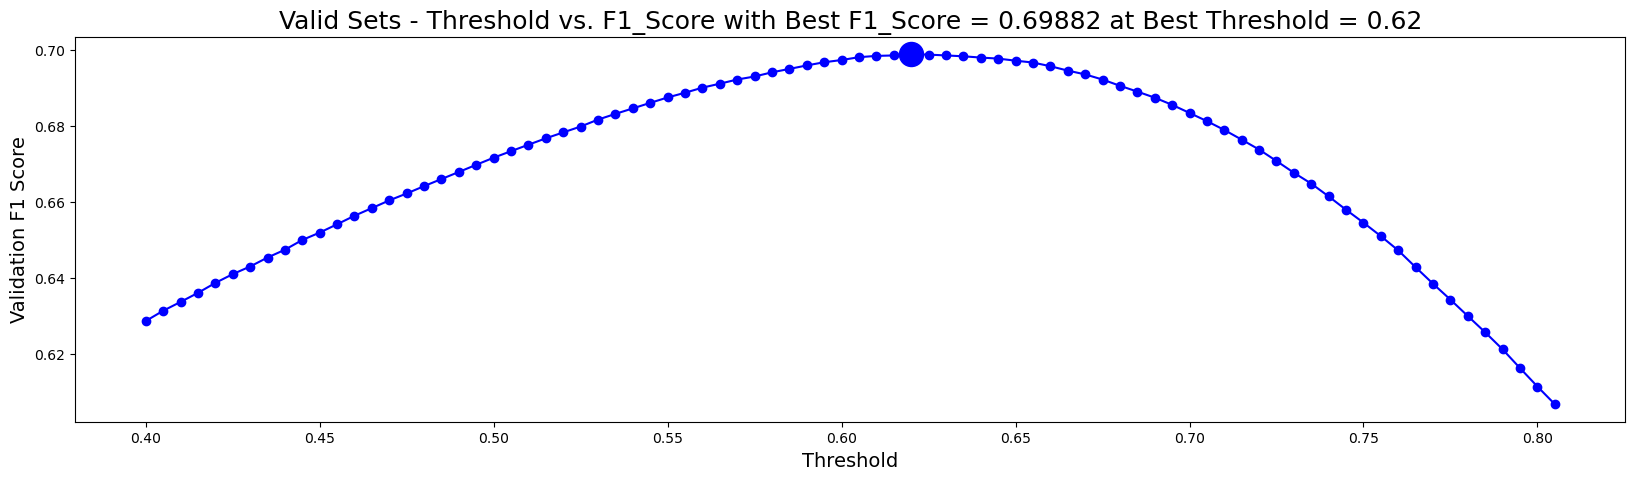

In [17]:
# For the valid data sets combined
true = oof_xgb.copy()

for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.005):
    print(f'{threshold:.03f}, ',end='')
    preds = (oof_xgb.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Valid Sets - Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
# plt.savefig('BestThreshold.png')
plt.show()

In [18]:
val_metrics = pd.DataFrame(data=np.zeros((18, 2)), columns=['f1','acc'])
# Print F1 Scores Question by Question
try:
    print('When using optimal threshold...')
    for k in range(1, 19):

        # COMPUTE F1 SCORE PER QUESTION
        m = f1_score(true[f'meta_{k}'].values, (oof_xgb[f'meta_{k}'].values>best_threshold_xgb).astype('int'), average='macro')
        val_metrics.loc[k,'f1'] = m
        print(f'Q{k}: F1 =',m)
        acc = accuracy_score(true[f'meta_{k}'].values, (oof_xgb[f'meta_{k}'].values>best_threshold_xgb).astype('int'))
        print(f'Q{k}: accuracy =', acc)
        val_metrics.loc[k,'acc'] = acc

        val_metrics.to_csv('./temp.csv')   
except:
    print('Something went wrong.....')


"""
When using optimal threshold...
Q1: F1 = 0.6727339085111161
Q1: accuracy = 0.744503862150921
Q2: F1 = 0.5224915287346688
Q2: accuracy = 0.9784823020117138
Q3: F1 = 0.5125735785255072
Q3: accuracy = 0.9340463458110517
Q4: F1 = 0.6798776224579769
Q4: accuracy = 0.8177149647737884
Q5: F1 = 0.6385614906037091
Q5: accuracy = 0.6389949919361684
Q6: F1 = 0.6466632795139867
Q6: accuracy = 0.7827009591715474
Q7: F1 = 0.6329021813717416
Q7: accuracy = 0.731304643069349
Q8: F1 = 0.5743216126844292
Q8: accuracy = 0.5814871403106697
Q9: F1 = 0.6354264478321615
Q9: accuracy = 0.7393684746625923
Q10: F1 = 0.6007637532018322
Q10: accuracy = 0.6145912910618793
Q11: F1 = 0.616936143930625
Q11: accuracy = 0.642602495543672
Q12: F1 = 0.5093396701330047
Q12: accuracy = 0.860920125626008
Q13: F1 = 0.477936113080043
Q13: accuracy = 0.735039470333588
Q14: F1 = 0.6385692591192023
Q14: accuracy = 0.7188693659281895
Q15: F1 = 0.6139118932597194
Q15: accuracy = 0.6343264578558696
Q16: F1 = 0.4944478994538106
Q16: accuracy = 0.7236227824463118
Q17: F1 = 0.5521948138205226
Q17: accuracy = 0.6561412443765385
Q18: F1 = 0.49154867381739503
Q18: accuracy = 0.9504710975299211
"""

"""When using optimal threshold...
Q1: F1 = 0.6719513830521383
Q1: accuracy = 0.7436974789915967
Q2: F1 = 0.5188364025602289
Q2: accuracy = 0.9783974195738901
Q3: F1 = 0.5158985059992583
Q3: accuracy = 0.933961463373228
Q4: F1 = 0.6783835106318948
Q4: accuracy = 0.8167388167388168
Q5: F1 = 0.6390671372225016
Q5: accuracy = 0.6395042865631101
Q6: F1 = 0.6479735174565622
Q6: accuracy = 0.7832102537984891
Q7: F1 = 0.6349968937604289
Q7: accuracy = 0.7318139376962907
Q8: F1 = 0.5753192300028308
Q8: accuracy = 0.5824632883456413
Q9: F1 = 0.6352710359135669
Q9: accuracy = 0.7378405907817672
Q10: F1 = 0.5989896074058259
Q10: accuracy = 0.6131907308377896
Q11: F1 = 0.6160002168466403
Q11: accuracy = 0.6411170528817588
Q12: F1 = 0.5074685110958681
Q12: accuracy = 0.8598590951532128
Q13: F1 = 0.4769431268706793
Q13: accuracy = 0.7347848230201172
Q14: F1 = 0.6394162496481979
Q14: accuracy = 0.7190815720227485
Q15: F1 = 0.6138809628784097
Q15: accuracy = 0.6339444868856634
Q16: F1 = 0.5013525313408143
Q16: accuracy = 0.7240471946354299
Q17: F1 = 0.5534123483614481
Q17: accuracy = 0.656692980222392
Q18: F1 = 0.4915930025414633
Q18: accuracy = 0.9505984211866565"""

When using optimal threshold...
Q1: F1 = 0.6719513830521383
Q1: accuracy = 0.7436974789915967
Q2: F1 = 0.5188364025602289
Q2: accuracy = 0.9783974195738901
Q3: F1 = 0.5158985059992583
Q3: accuracy = 0.933961463373228
Q4: F1 = 0.6783835106318948
Q4: accuracy = 0.8167388167388168
Q5: F1 = 0.6390671372225016
Q5: accuracy = 0.6395042865631101
Q6: F1 = 0.6479735174565622
Q6: accuracy = 0.7832102537984891
Q7: F1 = 0.6349968937604289
Q7: accuracy = 0.7318139376962907
Q8: F1 = 0.5753192300028308
Q8: accuracy = 0.5824632883456413
Q9: F1 = 0.6352710359135669
Q9: accuracy = 0.7378405907817672
Q10: F1 = 0.5989896074058259
Q10: accuracy = 0.6131907308377896
Q11: F1 = 0.6160002168466403
Q11: accuracy = 0.6411170528817588
Q12: F1 = 0.5074685110958681
Q12: accuracy = 0.8598590951532128
Q13: F1 = 0.4769431268706793
Q13: accuracy = 0.7347848230201172
Q14: F1 = 0.6394162496481979
Q14: accuracy = 0.7190815720227485
Q15: F1 = 0.6138809628784097
Q15: accuracy = 0.6339444868856634
Q16: F1 = 0.501352531340814

'\nWhen using optimal threshold...\nQ1: F1 = 0.6727339085111161\nQ1: accuracy = 0.744503862150921\nQ2: F1 = 0.5224915287346688\nQ2: accuracy = 0.9784823020117138\nQ3: F1 = 0.5125735785255072\nQ3: accuracy = 0.9340463458110517\nQ4: F1 = 0.6798776224579769\nQ4: accuracy = 0.8177149647737884\nQ5: F1 = 0.6385614906037091\nQ5: accuracy = 0.6389949919361684\nQ6: F1 = 0.6466632795139867\nQ6: accuracy = 0.7827009591715474\nQ7: F1 = 0.6329021813717416\nQ7: accuracy = 0.731304643069349\nQ8: F1 = 0.5743216126844292\nQ8: accuracy = 0.5814871403106697\nQ9: F1 = 0.6354264478321615\nQ9: accuracy = 0.7393684746625923\nQ10: F1 = 0.6007637532018322\nQ10: accuracy = 0.6145912910618793\nQ11: F1 = 0.616936143930625\nQ11: accuracy = 0.642602495543672\nQ12: F1 = 0.5093396701330047\nQ12: accuracy = 0.860920125626008\nQ13: F1 = 0.477936113080043\nQ13: accuracy = 0.735039470333588\nQ14: F1 = 0.6385692591192023\nQ14: accuracy = 0.7188693659281895\nQ15: F1 = 0.6139118932597194\nQ15: accuracy = 0.6343264578558696\

Now we use full data to retrain our models with the best iterations, and save them. 

In [34]:
# Use all the data to train the final model

# ITERATE THRU QUESTIONS 1 THRU 18
for t in range(1,19):

    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1 + [f'pre{i}' for i in range(1, t)]
    elif t<=13: 
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2 + [f'pre{i}' for i in range(4, t)]
    elif t<=22: 
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3 + [f'pre{i}' for i in range(14, t)]
    
    n_estimators = int(np.median(best_iteration_xgb[str(t)]) + 1)
    xgb_params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'tree_method': 'gpu_hist',
        'eval_metric':'logloss',
        'learning_rate': 0.01,
        'alpha': 8,
        'max_depth': 4,
        'n_estimators': n_estimators,
        #'early_stopping_rounds': 100,
        'subsample':0.5,
        'colsample_bytree': 0.3,
        'seed': 42,
        'reg_lambda': 0.1,
        'gamma': 2

    }
    
    print('#'*25)
    print(f'### question {t} features {len(FEATURES)}')
        
    # TRAIN DATA
    train_users = df.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

    # TRAIN MODEL        
    clf =  XGBClassifier(**xgb_params)
    clf.fit(df[FEATURES].astype('float32'), train_y['correct'], verbose=0)
    clf.save_model(f'XGB_question{t}.xgb')

    # Get the previous answers into features
    df[f'pre{t}'] = clf.predict_proba(df[FEATURES].astype('float32'))[:,1]
    
    print()

#########################
### question 1 features 878

#########################
### question 2 features 879

#########################
### question 3 features 880

#########################
### question 4 features 1474

#########################
### question 5 features 1475

#########################
### question 6 features 1476

#########################
### question 7 features 1477

#########################
### question 8 features 1478

#########################
### question 9 features 1479

#########################
### question 10 features 1480

#########################
### question 11 features 1481

#########################
### question 12 features 1482

#########################
### question 13 features 1483

#########################
### question 14 features 1777

#########################
### question 15 features 1778

#########################
### question 16 features 1779

#########################
### question 17 features 1780

#########################
### question 18 f

We save features names as dict for each questions

In [35]:
importance_dict = {}
for t in range(1, 19):
    if t<=3: 
        importance_dict[str(t)] = FEATURES1 + [f'pre{i}' for i in range(1, t)]
    elif t<=13: 
        importance_dict[str(t)] = FEATURES2 + [f'pre{i}' for i in range(4, t)]
    elif t<=22:
        importance_dict[str(t)] = FEATURES3 + [f'pre{i}' for i in range(14, t)]

f_save = open('importance_dict.pkl', 'wb')
pickle.dump(importance_dict, f_save)
f_save.close()

In [37]:
f_save = open('fqid_text_interaction.pkl', 'wb')
pickle.dump(fqid_text_interaction, f_save)
f_save.close()
